In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from synchrad.calc import SynchRad
from synchrad.utils import r_e, omega_1m, alpha_fs

from scipy.constants import e, m_e, c, epsilon_0, hbar
from scipy.integrate import solve_ivp

# Example of the undulator radiation

## Defining undulator and particle parameter

In [2]:
Np = 1            # Number of electrons
Num_osc = 50      # Number of oscillations

# Undulator
lambda_u = 15e-3
K0 = 0.1

# particles/beam central energy
particle_energy_MeV = 100

# Technical parameters
gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
pz0 = (gamma_0**2 - 1 - K0**2)**.5

omega_u = 2 * np.pi * c / lambda_u
omega_u_rad = 2 * gamma_0**2 * omega_u / (1 + K0**2 / 2)
lambda_u_rad = omega_1m/omega_u_rad

L_u = Num_osc * lambda_u
T_fin  = L_u / c

# Resolving track with 64 steps per oscillation
Nt = L_u/lambda_u * 64

trak0 = np.zeros((6, Np))
trak0[-1, :] = pz0 * (1 + 1e-3 * np.random.randn(Np))

# Correct particle injection angle
trak0[-3, :] = -K0 
    
t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

## Solving equations of particle motion in the ideal undulator field

In [3]:
def motion_undulator(t, track, K0, omega_u):
    x, y, z, ux, uy, uz = track
    
    gamma_p = np.sqrt(1.0 + ux**2 + uy**2 +  uz**2)
    
    dx = c * ux / gamma_p
    dy = c * uy / gamma_p
    dz = c * uz / gamma_p
    
    dux = K0 * omega_u * uz / gamma_p * np.sin(omega_u/c * z)
    duy = 0.0
    duz = -K0 * omega_u * ux / gamma_p * np.sin(omega_u/c * z)
    
    return dx, dy, dz, dux, duy, duz

tracks = []

# coordinates and momenta tracks are staggered by a half time-step (leat-frog)
for ip in range(Np):
    x_, y_, z_, ux, uy, uz = solve_ivp( motion_undulator, [0, T_fin], trak0[:, ip], 
                                     t_eval=t_eval, args=(K0, omega_u),
                                     method='Radau' ).y
    
    x, y, z, ux_, uy_, uz_ = solve_ivp( motion_undulator, [0, T_fin+dt/2], trak0[:, ip], 
                                     t_eval=t_eval+dt/2, args=(K0, omega_u),
                                     method='Radau' ).y
    
    tracks.append([x, y, z, ux, uy, uz, 1.0, 0.0])

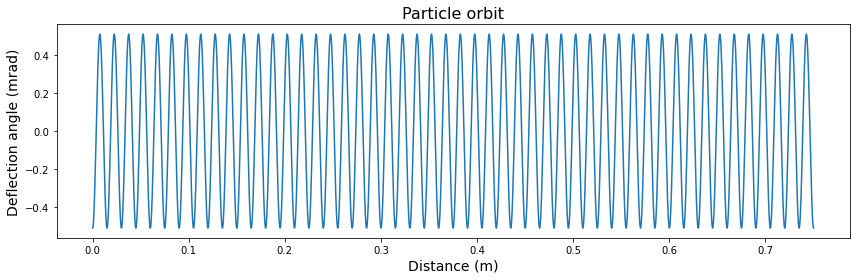

In [4]:
fig = plt.figure(figsize=(12,4), tight_layout=True)
x, y, z, ux, uy, uz, w, id_start = tracks[0]
plt.plot(z, np.arctan2(ux, uz)*1e3)

plt.title('Particle orbit', fontsize=16)
plt.xlabel('Distance (m)', fontsize=14)
plt.ylabel('Deflection angle (mrad)', fontsize=14);

## Setup SychRad and run the calculation

In [5]:
calc_input = {
    "grid": [
        (0.2*omega_u_rad/omega_1m, 1.1 * omega_u_rad/omega_1m),  
        (0, 1/gamma_0),
        (0.0, 2 * np.pi),
        (1024, 64, 64),
    ],  
}

calc = SynchRad(calc_input)
calc.calculate_spectrum( particleTracks=tracks, timeStep=c*dt )

Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used


## Check if photon number agrees with the theory

In [6]:
EnergyEmitted = calc.get_energy(lambda0_um=lambda_u*1e6, phot_num=True, normalize_to_weights=True)
EnergyEstimate = (7*np.pi*alpha_fs/24) * K0**2 * (1+K0**2/2) * Num_osc

error = (EnergyEmitted - EnergyEstimate) /  EnergyEstimate

print(f'Deviation of emitted photon number from analytic estimate {error*100:.1f} %')

Deviation of emitted photon number from analytic estimate 12.0 %


## Some plots of radiation functions

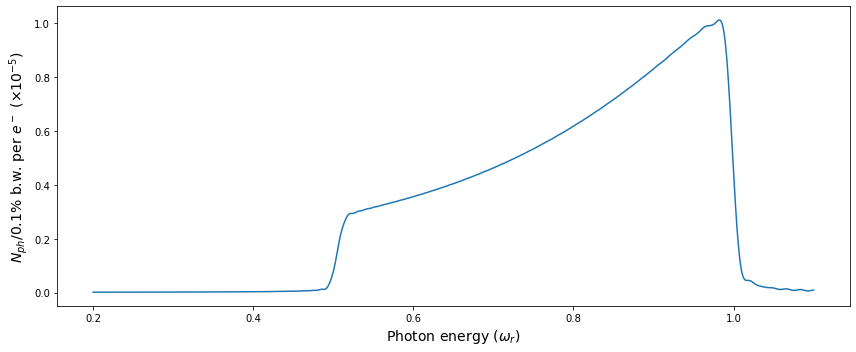

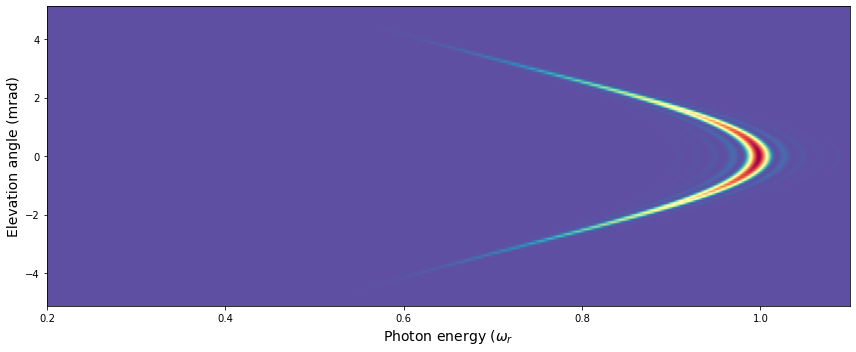

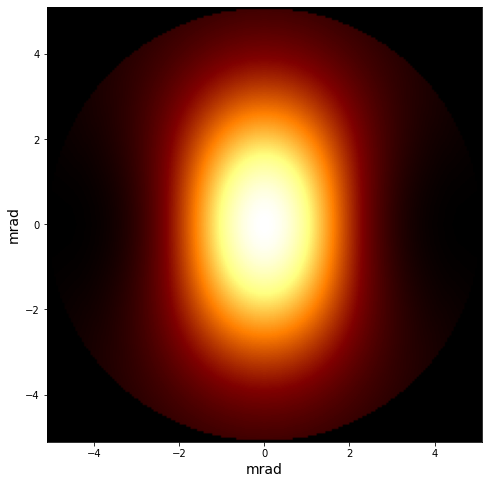

In [7]:
spect_val = calc.get_energy_spectrum(normalize_to_weights=True)
spect_val *= 1e-3
spect_ax_normalized = calc.get_spectral_axis() * omega_1m/omega_u_rad

plt.figure(figsize=(12,5), tight_layout=True)
plt.plot(spect_ax_normalized, spect_val * 1e5 )
plt.xlabel(r'Photon energy ($\omega_r$)', fontsize=14)
plt.ylabel(r'$N_{ph}$/0.1% b.w. per $e^-$ ($\times 10^{-5}$)', fontsize=14)

extent = [spect_ax_normalized.min(), 
          spect_ax_normalized.max(), 
          -calc.Args['theta'].max()* 1e3,
          calc.Args['theta'].max()* 1e3 ]

spect_val = calc.get_full_spectrum()
spect_val = np.c_[spect_val[:,:,spect_val.shape[2]//2-1][:,::-1], 
                  spect_val[:,1:,0]]

plt.figure(figsize=(12,5), tight_layout=True)
plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', aspect='auto')
plt.xlabel(r'Photon energy ($\omega_r$', fontsize=14)
plt.ylabel('Elevation angle (mrad)', fontsize=14);

spot, extent = calc.get_spot_cartesian(bins=(200, 200))

plt.figure(figsize=(8,8))
plt.imshow( spot.T,
            extent=extent*1e3, cmap=plt.cm.afmhot,
            origin='lower')
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];

## Spot  observed with a band-filter

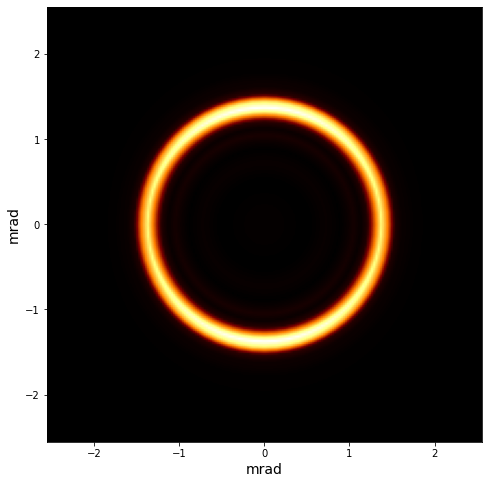

In [8]:
kFilter = 0.93 * omega_u_rad / omega_1m
kBand = 0.003 * kFilter
k = calc.Args['omega'][:,None,None]
spect_filter = np.exp( -(k-kFilter)**2/kBand**2 ) 

spot, extent = calc.get_spot_cartesian(bins=(200,200), th_part=0.5, spect_filter=spect_filter)

plt.figure(figsize=(8,8))
plt.imshow(spot.T,
            extent=extent*1e3, cmap=plt.cm.afmhot,
            origin='lower' )
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];